# Task 1 Notebook

For Task 1, we explored the data with the two main things that we identified as important being the timestep (delta t) and how much images change between frames. 

In [3]:
# data handling and visualization package
import exp

In [4]:
# loading all storm data to a data frame so that we can inspect it
data_df = exp.load_data_to_df()

### Initial Data Exploration

In [5]:
data_df.head()

,storm_id,relative_time,ocean,wind_speed,image
0,bkh,0,1,25,"[[[tensor(14, dtype=torch.uint8), tensor(14, d..."
1,bkh,1801,1,25,"[[[tensor(15, dtype=torch.uint8), tensor(15, d..."
2,bkh,3600,1,25,"[[[tensor(20, dtype=torch.uint8), tensor(19, d..."
3,bkh,5400,1,25,"[[[tensor(16, dtype=torch.uint8), tensor(14, d..."
4,bkh,7200,1,25,"[[[tensor(15, dtype=torch.uint8), tensor(16, d..."


In [34]:
print(len(data_df))

9527


In [9]:
# ensuring that we do not having any duplicates (duplicate files were an issue initially when we were
# loading in the data)
((data_df.duplicated())==False).value_counts().sum()

9527

In [12]:
# there are no NAN values in the time and wind speed columns
print((data_df['wind_speed'].isna() == True).value_counts)
print((data_df['relative_time'].isna() == True).value_counts)

<bound method IndexOpsMixin.value_counts of 0       False
1       False
2       False
3       False
4       False
        ...  
9522    False
9523    False
9524    False
9525    False
9526    False
Name: wind_speed, Length: 9527, dtype: bool>
<bound method IndexOpsMixin.value_counts of 0       False
1       False
2       False
3       False
4       False
        ...  
9522    False
9523    False
9524    False
9525    False
9526    False
Name: relative_time, Length: 9527, dtype: bool>


In [4]:
# ensuring that we do indeed have all of the storms in the dataframe, and we do.
data_df["storm_id"].unique()

array(['bkh', 'blq', 'dzw', 'eoi', 'fgi', 'fna', 'gic', 'gkf', 'gme',
       'hig', 'ing', 'ipa', 'kqu', 'mtw', 'ojv', 'pjj', 'psz', 'pvj',
       'qpq', 'rml', 'sxb', 'vxf', 'vye', 'woc', 'wsy', 'xjo', 'yfn',
       'ywf', 'zny', 'ztb'], dtype=object)

In [5]:
# printing out the shape of the image so we know the size of the data we are working with
(data_df['image'][0]).shape

torch.Size([1, 366, 366])

### Model Specific Data Exploration

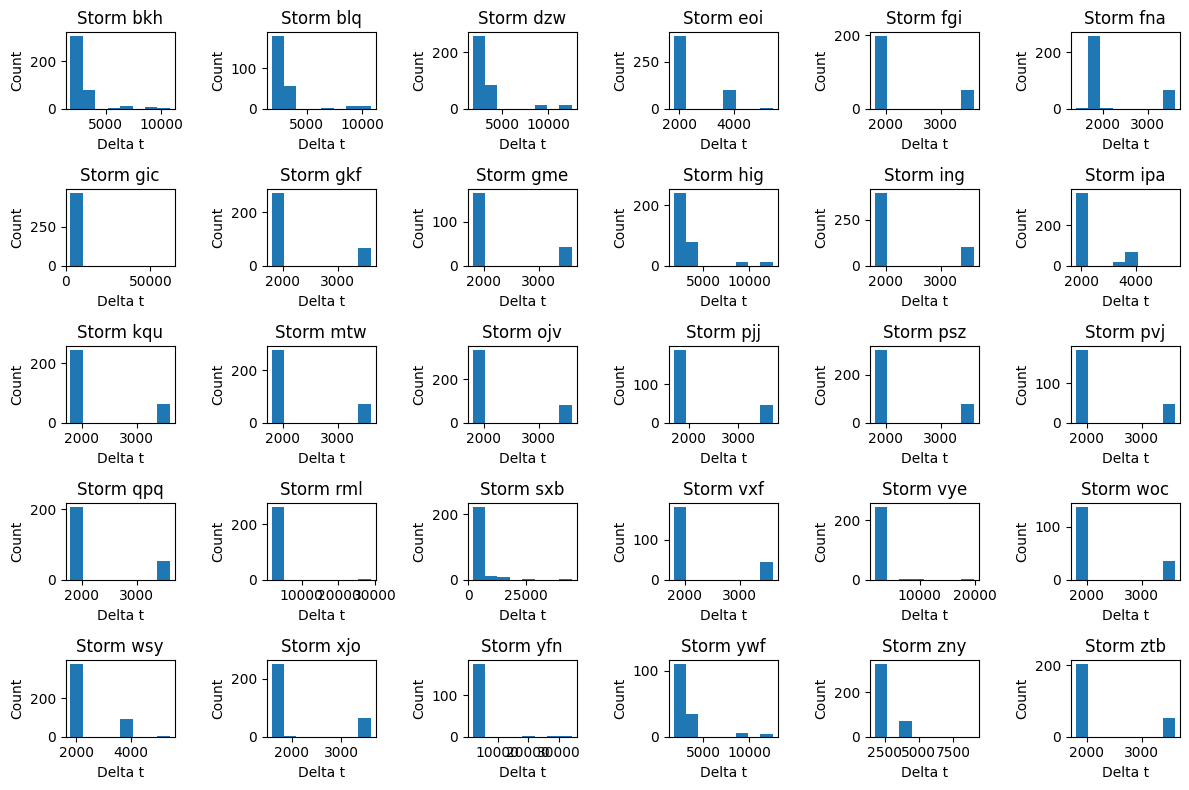

In [6]:
# below, we can see histograms of delta t for each storm. this gives us an idea of how varied our
# timesteps are going to be, and if it's worth considering them as a feature in our model
exp.delta_t_hists(data_df)

#### Althought the timesteps (delta t) are not consistent throughout the progression of them storm, it looks like for the most part, the that the time steps are largely the same with just a few larger time gaps. This means that we may be able to ignore the fact that the time data are unevenly spaced, due to the marginal degree that unevenness occurs. 

#### This observation is important for both models, but possibly more important for the sequential image generation because it is directly contingent on time


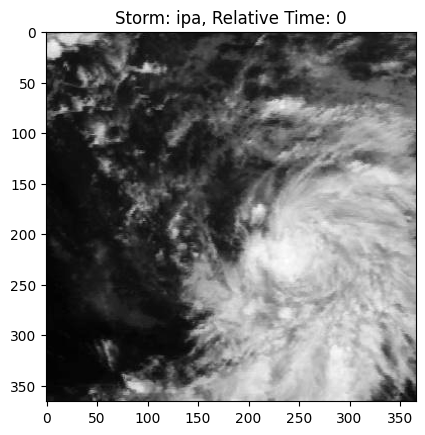

In [14]:
# now, we will inspect some of the images 
exp.show_image(data_df, 'ipa', 0)

### Plotting multiple images side by side so that we can inspect the change in images visually.

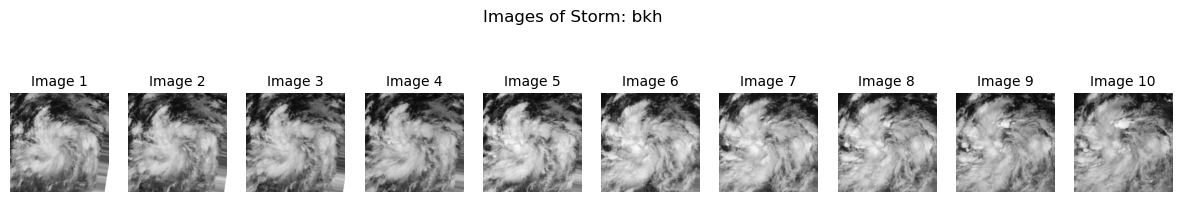

In [15]:
exp.show_multiple_images(data_df, 'bkh', 0, 10)

On initial inspection, we can see that variation between images is small which will present a challenge for a model. This was observed across all storms. It is possible that the predicted images might end up looking the same. The model may struggle to detect small variations from image to image and thus have trouble replicating sequential data. This means that we have to be very careful chosing the loss function for this model.  

Additionally, when doing ToTensor() transformation for the model input, we get images that are normalised between 0-1, because pytorch ToTensor has this inbuilt functionality. 

Because of the above points, we decided to go with SSIM as a loss function, since it takes into account the structural similarity between images, which is more important than intensity values as it is with MSE loss.

# Model Architecture 

Ten consecutive input images are fed into the model to generate the prediction. All of them are reduced to size 360x360 as this was discovered to be the most optimal. They are converted to grayscale and to tensors.

The final model design includes a CNN for preprocessing the images and extracting features. The output kernels are then fed into a ConvLSTM whihc produces the next image in the sequence. This then has to be upsampled to the appropriate output size by Transpose Convolution Networks. 

In [30]:
# imports
import sys
sys.path.append('./task1_package')
from dataloader import CustomDataset, train_test_split, create_combined_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from model_train_test import train_model
from model import ConvLSTM, ImageSequencePredictor
from loss_func import SSIMLoss
from generate_image import predict_and_display_images
from image_comparision import compare_predicted_and_target_images

No GPU available!


### Dataset Loading and Dataset Preprocessing

In [31]:
# Create desired transfromation
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((360, 360)), 
    transforms.ToTensor() 
])

folder_path = './Selected_Storms'

# Input sequence length
sequence = 10

# Generate the custom dataset and do train/test split to feed into data loader for training
combined_dataset = create_combined_dataset(folder_path, sequence, transform=transform)

train_dataset, test_dataset = train_test_split(combined_dataset, test_ratio=0.2)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Training Model

In [ ]:
# Define model hyperparameters
input_dim = 64
hidden_dim = [128,64]
kernel_size = (3,3)
num_layers = 2 # number of ConvLSTM layers

# Create model
model = ImageSequencePredictor(input_dim, hidden_dim, kernel_size, num_layers)

# Define loss function and optimiser
criterion = SSIMLoss(window_size=11, size_average=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

### Generate Images and Compare

No GPU available, running on CPU.


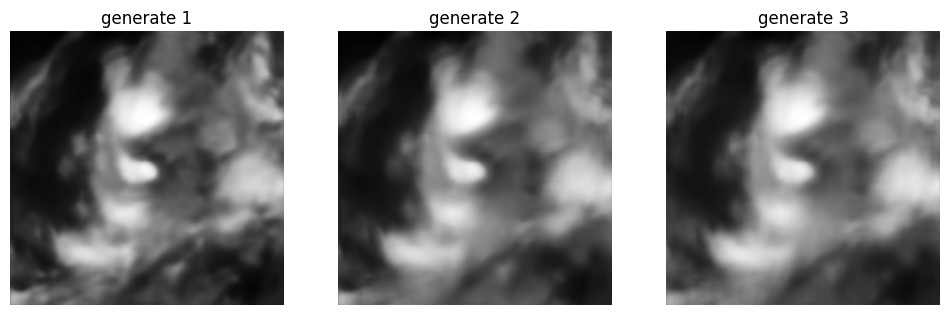

No GPU available, running on CPU.


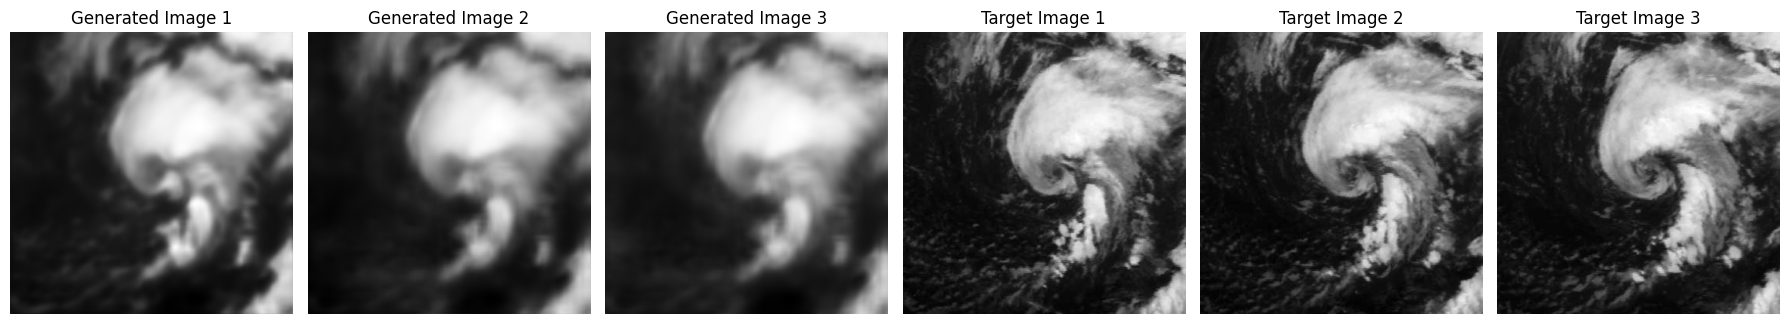

In [5]:
# generate and save image
predict_and_display_images('Selected_Storms_curated_to_zip/bkh','bkh_', 242, 251,'acds-the-day-after-tomorrow-jocelyn-11-task-1-sustainability-packaging/task1_package/best_model.pth')
# compare predicted and target images
compare_predicted_and_target_images('acds-the-day-after-tomorrow-jocelyn-11-task-1-sustainability-packaging/task1_package/best_model.pth', test_loader, index=2)

** Here we can see that the images are similar in nature to the target images, however the reslolution of the images is much lower. 